**IMPORTS**

In [22]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from nltk.tokenize import word_tokenize
import nltk
import re
import os
import string
import json

In [23]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rakesh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**LOAD DATA**

In [24]:
file_path = "./data/IMDB_Data.csv"
data = pd.read_csv(file_path)
data.head()

,Unnamed: 0,review,sentiment
0,41967,I got the DVD very cheap and I'm a total Drewb...,negative
1,33842,I liked this comedy so much. Will Smith does n...,positive
2,47000,What a piece of junk this movie was. The premi...,negative
3,16580,"I am a big fan of the movie, but not for the u...",positive
4,39715,Im going to keep this fairly brief as to not s...,positive


In [25]:
data['review'].iloc[50], data['sentiment'].iloc[50]

('When people harp on about how "they don\'t make \'em like they used to" then just point them towards this fantastically entertaining, and quaint-looking, comedy horror from writer-director Glenn McQuaid.<br /><br />It\'s a tale of graverobbers (played by Dominic Monaghan and Larry Fessenden) who end up digging up more than just silent, immobile corpses. After the initial shock of this they soon realise that they can actually turn the situation to their advantage. And that\'s just what they try to do. Mind you, it seems as if things may not have worked out quite as they planned as poor young Arthur (Monaghan) is actually relating his tale to a priest (Ron Perlman) before being taken to the gallows.<br /><br />Looking at the detail of his filmography, McQuaid seems to have taken the core of his first, short movie and expanded it to this feature effort, which is no bad thing. Fessenden returns and does well, Monaghan is one of those guys who can actually still get you to like him while 

In [26]:
data['review'].iloc[0], data['sentiment'].iloc[0]

("I got the DVD very cheap and I'm a total Drewbie, and thats probably the only constellation where this movie could ever interest anyone.<br /><br />An early Drew movie, she's looking great, and she gets a quite lot of really cute scenes of her, like a shower scene, a sexy dance scene, quite a number of sexy outfits etc. She does never show the friendly charm we know from her more recent movies.<br /><br />The movie itself is pretty average or sub-average, and much more looking like being made for the TV than one for the cinema. There is no real horror or tension built up and the dialogs are often cheesy.<br /><br />The most interesting part is probably the end because I honestly don't understand it. But maybe there is nothing to understand about it anyway. But at least you don't get the end you would be expecting, and it also comes much sooner than one would have expected.<br /><br />Overall I think this movie is exclusively for Drewbies.",
 'negative')

**TEXT CLEANING**

In [27]:
def clean_text(text):
    text = text.lower()
    text = re.sub('<.*?>+', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\s+', ' ', text)
    return text.strip()



In [28]:
clean_text(data['review'].iloc[50])

'when people harp on about how they don t make em like they used to then just point them towards this fantastically entertaining and quaint looking comedy horror from writer director glenn mcquaid it s a tale of graverobbers played by dominic monaghan and larry fessenden who end up digging up more than just silent immobile corpses after the initial shock of this they soon realise that they can actually turn the situation to their advantage and that s just what they try to do mind you it seems as if things may not have worked out quite as they planned as poor young arthur monaghan is actually relating his tale to a priest ron perlman before being taken to the gallows looking at the detail of his filmography mcquaid seems to have taken the core of his first short movie and expanded it to this feature effort which is no bad thing fessenden returns and does well monaghan is one of those guys who can actually still get you to like him while he goes about the nefarious business of stealing f

In [29]:
# Apply text cleaning
data['review'] = data['review'].apply(clean_text)
print(data['review'].head())

0    i got the dvd very cheap and i m a total drewb...
1    i liked this comedy so much will smith does no...
2    what a piece of junk this movie was the premis...
3    i am a big fan of the movie but not for the us...
4    im going to keep this fairly brief as to not s...
Name: review, dtype: object


**TOKENIZATION**

In [30]:
vocab = Counter()
for review in data['review']:
    tokens = word_tokenize(review)
    vocab.update(tokens)

N = 5000
vocab = {word: i + 1 for i, (word, _) in enumerate(vocab.most_common(N))}
vocab['<PAD>'] = 0

max_length = 200

In [31]:
# vocab

**X-Y SPLIT**

In [32]:
X = [[vocab.get(word, 0) for word in word_tokenize(review)] for review in data['review']]
X = [review[:max_length] + [vocab['<PAD>']] * (max_length - len(review)) for review in X]
X = np.array(X)
y = (data['sentiment'] == 'positive').astype(int).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
len(X), len(X[0]), X

(5000,
 200,
 array([[   9,  196,    1, ...,    0,    0,    0],
        [   9,  431,   10, ...,  467,    0,    0],
        [  48,    3,  410, ...,    0,    0,    0],
        ...,
        [   9,  103, 3234, ...,  103,   11, 2283],
        [  10,    6,   33, ...,    0,    0,    0],
        [1572,   15,    1, ...,   68, 2447,    7]]))

In [34]:
len(y), y

(5000, array([0, 1, 0, ..., 1, 0, 1]))

**---LOADER---**

In [35]:
class TextReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 128
train_dataset = TextReviewDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)


**SENTIMENT MODEL**

In [36]:
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        h0, _ = self.lstm(x)
        h0 = h0[:, -1, :]
        out = self.fc(h0)
        return self.sigmoid(out)


**PARAMS & MODEL INITIALIZATION**

In [37]:
vocab_size = len(vocab)
embedding_dim = 72
hidden_dim = 128
output_dim = 1
dropout = 0.5
model = SentimentModel(vocab_size, embedding_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 12

**MODEL TRANING**

In [38]:
for epoch in tqdm(range(epochs), desc="Training Epochs"):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss/len(train_loader):.4f}")


Training Epochs:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1/12 - Loss: 0.7085
Epoch 2/12 - Loss: 0.6910
Epoch 3/12 - Loss: 0.6796
Epoch 4/12 - Loss: 0.6624
Epoch 5/12 - Loss: 0.6342
Epoch 6/12 - Loss: 0.5810
Epoch 7/12 - Loss: 0.5428
Epoch 8/12 - Loss: 0.4786
Epoch 9/12 - Loss: 0.4246
Epoch 10/12 - Loss: 0.4031
Epoch 11/12 - Loss: 0.3720
Epoch 12/12 - Loss: 0.3406


**EVALUATE MODEL**

Test Accuracy: 75.30%
Test Precision: 77.35%
Test Recall: 70.26%
Test F1 Score: 73.64%
Metrics and confusion matrix saved to model_evaluation.xlsx


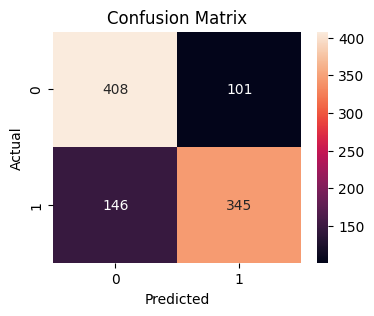

In [39]:
test_dataset = TextReviewDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch).squeeze()
            predictions = (predictions > 0.5).float()
            y_true.extend(y_batch.numpy())
            y_pred.extend(predictions.numpy())
    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    # Print metrics
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    print(f'Test Precision: {precision * 100:.2f}%')
    print(f'Test Recall: {recall * 100:.2f}%')
    print(f'Test F1 Score: {f1 * 100:.2f}%')

    os.makedirs('./evaluation-scores', exist_ok=True)
    # Save the scores to an Excel file
    scores_df = pd.DataFrame({'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1 Score': [f1]})
    scores_df.to_excel('./evaluation-scores/evaluation_scores-test-model.xlsx', index=False)
    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('./evaluation-scores/confusion_matrix-test-model.png')
    print('Metrics and confusion matrix saved to model_evaluation.xlsx')
    
    return accuracy, precision, recall, f1, conf_matrix

# Evaluate the model
accuracy, precision, recall, f1, conf_matrix = evaluate_model(model, test_loader)

**SAVE THE MODEL**

In [40]:
os.makedirs('./saved-model', exist_ok=True)

In [41]:
# Save the entire model
torch.save(model, './saved-model/test-model.pth')

**LOAD THE SAVED MODEL**

In [42]:
# Load the entire model
loadedmodel = torch.load('./saved-model/test-model.pth')


**FUNCTION TO PREDICT FROM LOADED MODEL**

In [43]:
def predict_sentiment(sentence, model, vocab, max_length=200):
    sentence = clean_text(sentence)
    tokens = word_tokenize(sentence)
    token_ids = [vocab.get(token, 0) for token in tokens]
    token_ids = token_ids[:max_length] + [vocab['<PAD>']] * (max_length - len(token_ids))
    token_ids_tensor = torch.tensor(token_ids, dtype=torch.long).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        prediction = model(token_ids_tensor).squeeze().item()
    return "positive" if prediction > 0.5 else "negative"


**SENTIMENT PREDICTION**

In [44]:
sentence = "The movie was good"
# sentence = "Thank god for karan johar otherwise we would have missed out so many interesting movies"
sentiment = predict_sentiment(sentence, loadedmodel, vocab, max_length)
print(f"The predicted sentiment for the sentence is: {sentiment}")

The predicted sentiment for the sentence is: positive
